In [100]:
#This notebook is about predictive Maintanence.
#I applied this kind of algorithm for validity of an advertisement before.
#here i found a dataset from net and a sample from blog.
#i changed the encoding and some methods according to my needs for using in future.
#Resnet is very usefull when we want to train deep networks 

In [99]:
#!pip install llvmlite --ignore-installed
#!pip install  librosa


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import itertools
import os

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *

import librosa

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [102]:
### READ AND CONCAT DATA ###
main_data_path = "D:/datamaintanance/hydraulicsystems/"
label = pd.read_csv(main_data_path+'profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']
label.head(5)

,Cooler,Valve,Pump,Accumulator,Flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [103]:
#take 1 variable ,it has 5999 measurements
df = pd.read_csv(main_data_path+'EPS1.txt', sep='\t', header=None)

print(df.shape)
df.head(1)

(2205, 6000)


,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2411.6,2409.6,...,2409.6,2409.2,2409.6,2409.4,2409.6,2409.4,2409.6,2409.6,2409.6,2409.6


Text(0.5, 0, 'Time')

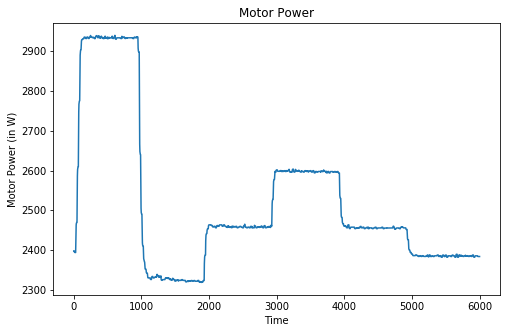

In [104]:
#Plot variable
df.iloc[2,:].plot(figsize=(8,5), title='Motor Power')
plt.ylabel('Motor Power (in W)'); 
plt.xlabel('Time')

In [105]:
#we will loose 1 dimension while using diff

df = df.values
df = np.clip(np.diff(df, axis=1), -5,5)
df.shape

(2205, 5999)

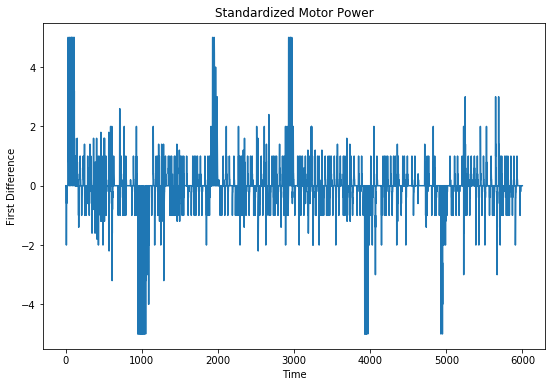

In [106]:
### PLOT STANDARDIZED DATA ###

plt.figure(figsize=(9,6))
plt.plot(df[2])
plt.title('Standardized Motor Power')
plt.ylabel('First Difference'); plt.xlabel('Time')
np.set_printoptions(False)

In [107]:
#Flag 0 means system did not break at the end of sequence
#Flag 1 means system failure at the end of sequence

label = label.Flag
print(label.value_counts())
diz_label = {0:'stable', 1:'not stable'}
y = to_categorical(label)

0    1449
1     756
Name: Flag, dtype: int64


In [108]:
df_flat = []

for i,sample in enumerate(tqdm.tqdm(df)):
    
    sample_append = np.append( sample , [sample[len(sample)-1]] )
    sample_meaned = np.mean(sample_append.reshape(-1, 10), axis=1).reshape(20,30)
    df_flat.append(sample_meaned)
    

df_spectre = df_flat
df_spectre = np.array(df_spectre)
df_spectre.shape

100%|████████████████████████████████████████████████████████████████████████████| 2205/2205 [00:00<00:00, 7922.75it/s]


(2205, 20, 30)

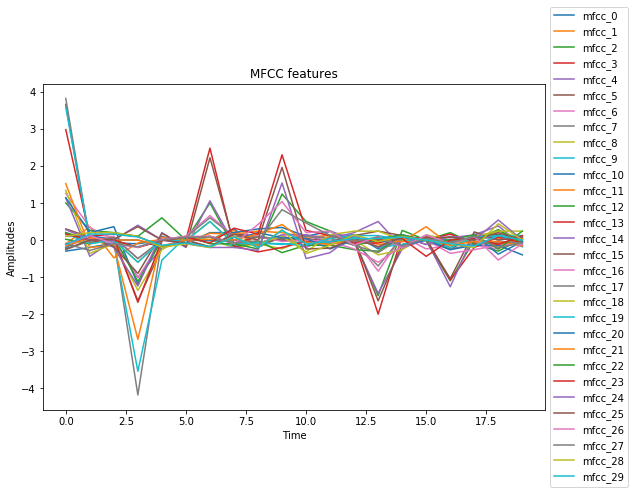

In [109]:
#plot single encoding

plt.figure(figsize=(9,6))

plt.plot(df_spectre[2])
plt.legend(['mfcc_'+str(i) for i in range(df_spectre.shape[-1])], 
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('MFCC features')
plt.ylabel('Amplitudes'); plt.xlabel('Time')

np.set_printoptions(False)

In [110]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df_spectre, y, random_state = 42, test_size=0.2)
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (1764, 20, 30)
X_test (441, 20, 30)
y_train (1764, 2)
y_test (441, 2)


In [111]:
### DEFINE RESNET CNN ###

def get_model(data):
        
    def residual_block(init, hidden_dim):
        
        init = Conv1D(hidden_dim, 3, activation='relu', padding="same")(init)
        
        x = Conv1D(hidden_dim, 3, activation='relu', padding="same")(init)
        x = Conv1D(hidden_dim, 3, activation='relu', padding="same")(x)
        x = Conv1D(hidden_dim, 3, activation='relu', padding="same")(x)
        skip = Add()([x, init])
        
        return skip
    
    inp = Input(shape=(data.shape[1], data.shape[2]))
    
    x = residual_block(inp, 256)
    x = residual_block(x, 128)
    x = residual_block(x, 32)
    x = GlobalMaxPool1D()(x)
    
    out = Dense(len(diz_label), activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [112]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=15)

model = get_model(X_train)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 20, 30)]     0                                            
__________________________________________________________________________________________________
conv1d_48 (Conv1D)              (None, 20, 256)      23296       input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 20, 256)      196864      conv1d_48[0][0]                  
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 20, 256)      196864      conv1d_49[0][0]                  
____________________________________________________________________________________________

In [113]:
model.fit(X_train, y_train, epochs=50, batch_size=256, verbose=1, validation_split=0.1, callbacks=[es])

Epoch 1/50
7/7 [==============================] - 3s 453ms/step - loss: 0.6388 - accuracy: 0.6181 - val_loss: 0.3837 - val_accuracy: 0.9322
Epoch 2/50
7/7 [==============================] - 3s 417ms/step - loss: 0.3574 - accuracy: 0.8412 - val_loss: 0.2990 - val_accuracy: 0.8644
Epoch 3/50
7/7 [==============================] - 3s 499ms/step - loss: 0.2813 - accuracy: 0.8759 - val_loss: 0.3243 - val_accuracy: 0.8249
Epoch 4/50
7/7 [==============================] - 3s 485ms/step - loss: 0.3116 - accuracy: 0.8557 - val_loss: 0.2405 - val_accuracy: 0.9153
Epoch 5/50
7/7 [==============================] - 4s 543ms/step - loss: 0.2475 - accuracy: 0.8986 - val_loss: 0.1822 - val_accuracy: 0.9379
Epoch 6/50
7/7 [==============================] - 4s 558ms/step - loss: 0.1969 - accuracy: 0.9212 - val_loss: 0.1480 - val_accuracy: 0.9492
Epoch 7/50
7/7 [==============================] - 4s 517ms/step - loss: 0.1779 - accuracy: 0.9263 - val_loss: 0.1515 - val_accuracy: 0.9492
Epoch 8/50
7/7 [====

In [121]:
print("X_train",X_train.shape)
print("y_train",y_train.shape)

X_train (1764, 20, 30)
y_train (1764, 2)


In [122]:
pred_test = np.argmax(model.predict(X_test), axis=1)

In [123]:
pred_test.shape


(441,)

In [124]:
print(classification_report([diz_label[np.argmax(label)] for label in y_test], 
                            [diz_label[label] for label in pred_test]))

              precision    recall  f1-score   support

  not stable       0.88      0.84      0.86       147
      stable       0.92      0.94      0.93       294

    accuracy                           0.91       441
   macro avg       0.90      0.89      0.90       441
weighted avg       0.91      0.91      0.91       441



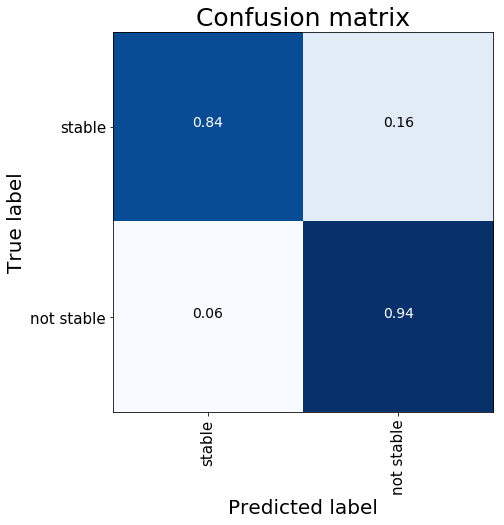

In [126]:
cnf_matrix = confusion_matrix([diz_label[np.argmax(label)] for label in y_test], 
                              [diz_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()))
plt.show()

In [127]:
#real distribution of samples distribution 

In [119]:
sum([diz_label[np.argmax(label)] == 'stable' for label in y_test]) / len(y_test)

0.6666666666666666

In [120]:
sum([diz_label[np.argmax(label)] == 'not stable' for label in y_test]) / len(y_test)

0.3333333333333333